# Fake news classification - Analysis and Modeling

In [1]:
# Importing the libraries.

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
import textstat as ts
from numpy.random import seed
seed(100)


nltk.download('stopwords')


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing the dataset.

data_path = "C:\\Users\\mehta\\Desktop\\deeplearning\\projects\\fakenews\\dataset"

true_news_data = pd.read_csv(data_path + "\\True.csv")
fake_news_data = pd.read_csv(data_path + "\\Fake.csv")

### Statistical & Visual data analysis

In [3]:
"""
A utility function to calculate the avg. length of the text (in number of words.)

"""

def avg_text_length(dataframe):
    rowCounts = [len(x.split()) for x in dataframe["text"].tolist()]
    avgCount = sum(rowCounts)//len(rowCounts)
    
    return avgCount

In [4]:
print("Avg. text length for true news: {}".format(avg_text_length(true_news_data)))
print("Avg. text length for fake news: {}".format(avg_text_length(fake_news_data)))

Avg. text length for true news: 385
Avg. text length for fake news: 423


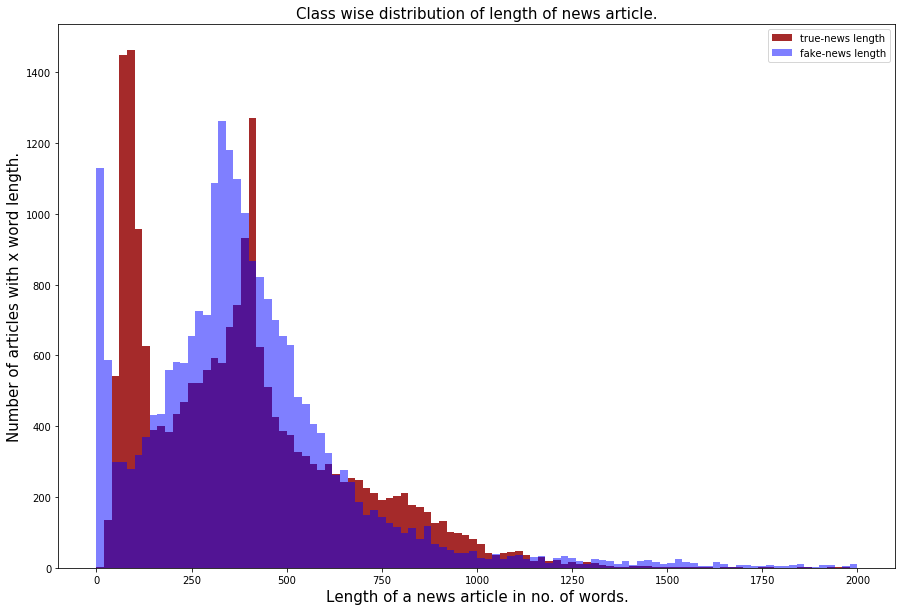

In [5]:
# Plotting the histogram for meaningful insights.

true_lengths = pd.Series([len(x.split()) for x in true_news_data["text"].tolist()])
fake_lengths = pd.Series([len(x.split()) for x in fake_news_data["text"].tolist()])

plt.figure(figsize = (15,10))
plt.hist(true_lengths, bins = 100, range = [0, 2000], color = "brown", label = "true-news length")
plt.hist(fake_lengths, bins = 100, range = [0, 2000], color = "blue", alpha = 0.5, label = "fake-news length")
plt.xlabel("Length of a news article in no. of words.", fontsize = 15)
plt.ylabel("Number of articles with x word length.", fontsize = 15)
plt.title("Class wise distribution of length of news article.", fontsize = 15)
plt.legend()
plt.show()

### Key inferences from histogram:

1. Rarely, a <b>true</b> news article contains more than 1400 words.

2. There are many <b>true</b> news articles with less than 250 words while the number of <b>fake</b> news articles with less than 250 words are comparitively lesser.

In [6]:
"""
A utility function to calculate the five number summary of the length of the text of news articles.

"""

def five_num_summary(dataframe):
    quartiles = np.percentile([len(x.split()) for x in dataframe["text"].tolist()], [0, 25, 50, 75, 100])
    
    return quartiles

In [7]:
true_summ = five_num_summary(true_news_data)

print("Text length - five number summary for true news data:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, true_summ[i//25]))
    
    
print("\n")


fake_summ = five_num_summary(fake_news_data)

print("Text length - five number summary for fake news data:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, fake_summ[i//25]))

Text length - five number summary for true news data:
0'th %ile: 0.0
25'th %ile: 148.0
50'th %ile: 359.0
75'th %ile: 525.0
100'th %ile: 5172.0


Text length - five number summary for fake news data:
0'th %ile: 0.0
25'th %ile: 240.0
50'th %ile: 363.0
75'th %ile: 506.0
100'th %ile: 8135.0


In [8]:
stopwords = nltk.corpus.stopwords.words("english")

"""
A utility function to calculate the average % of stopwords content in true and fake news.

"""

def stopwords_frequency(dataframe):
    words_list = [x.split() for x in dataframe["text"].tolist()]
    frequencies = []
    for row in words_list:
        if(len(row)) > 0:
            row_frequency = len([w for w in row if w in stopwords])
            row_frequency = (row_frequency/len(row))*100

            frequencies.append(row_frequency)
    
    avg = sum(frequencies)/len(frequencies)
    
    return avg

In [9]:
true_frequencies = stopwords_frequency(true_news_data)
fake_frequencies = stopwords_frequency(fake_news_data)

print("Average stopwords frequency in true-news: {}".format(true_frequencies))
print("Average stopwords frequency in fake-news: {}".format(fake_frequencies))

Average stopwords frequency in true-news: 36.12374342655998
Average stopwords frequency in fake-news: 39.509912127071104


In order to check for most frequent words in both the datasets, we plot wordcloud of text contents of both true and fake news data.

True news articles wordcloud.


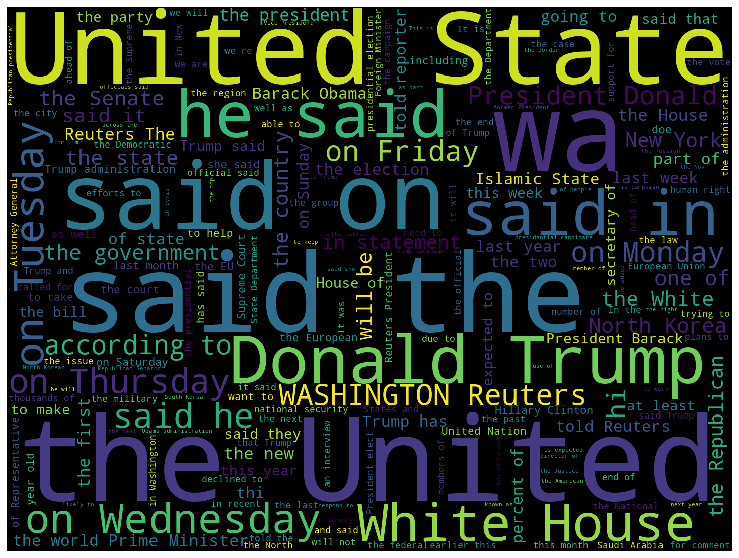

In [10]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(true_news_data["text"].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

print("True news articles wordcloud.")

Fake news articles wordcloud.


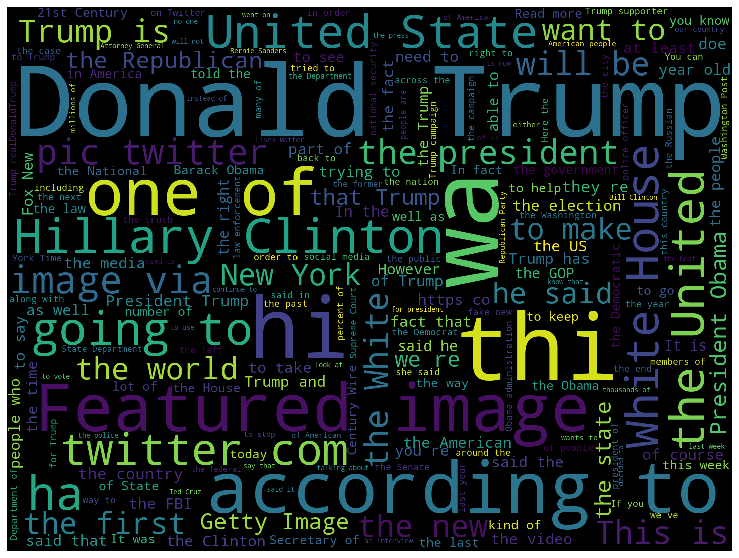

In [11]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(fake_news_data["text"].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

print("Fake news articles wordcloud.")

We can also experiment with the readability index for each true and fake news articles. 

For readability index, we use Flesch reading ease score formula which is as given below:

<b>RE = 206.835 – (1.015 x ASL) – (84.6 x ASW)</b>

<i>RE = Readability Ease</i>

<i>ASL = Average Sentence Length (i.e., the number of words divided by the number of sentences)</i>

<i>ASW = Average number of syllables per word (i.e., the number of syllables divided by the number of words)</i>

In [12]:
true_news_readability = []
fake_news_readability = []

for sentence in true_news_data["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    true_news_readability.append(temp)
    
for sentence in fake_news_data["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    fake_news_readability.append(temp)

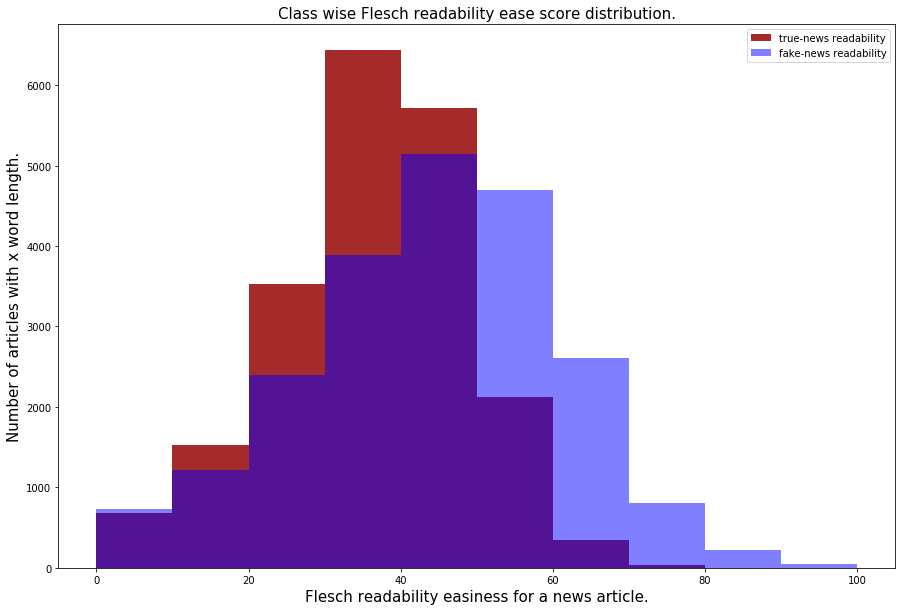

In [13]:
true_readability_df = pd.Series(true_news_readability)
fake_readability_df = pd.Series(fake_news_readability)

plt.figure(figsize = (15,10))
plt.hist(true_readability_df, bins = 10, range = [0, 100], color = "brown", label = "true-news readability")
plt.hist(fake_readability_df, bins = 10, range = [0, 100], color = "blue", alpha = 0.5, label = "fake-news readability")
plt.xlabel("Flesch readability easiness for a news article.", fontsize = 15)
plt.ylabel("Number of articles with x word length.", fontsize = 15)
plt.title("Class wise Flesch readability ease score distribution.", fontsize = 15)
plt.legend()
plt.show()

We can also check for a distribution which shows us top 50 dates with the maximum fake news articles released.

In [14]:
fake_datewise_counts = fake_news_data.groupby('date').date.agg([('count', 'count')]).reset_index().sort_values(by = "count", ascending = False)

fake_datewise_counts = fake_datewise_counts.head(50)

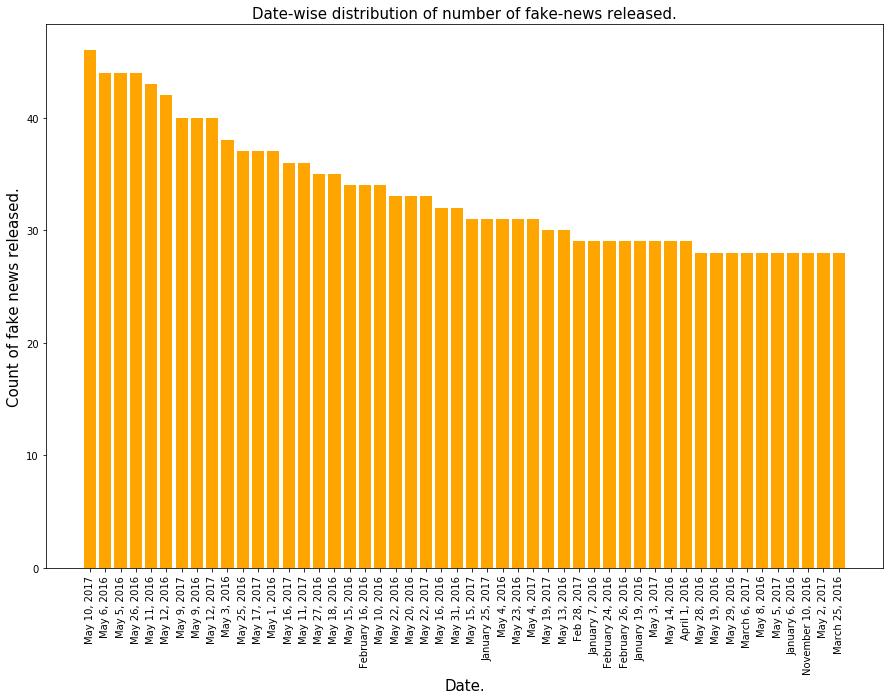

In [15]:
plt.figure(figsize = (15,10))
plt.xticks(rotation = 90)
plt.bar(fake_datewise_counts["date"], fake_datewise_counts["count"], align = "center", color = "orange")
plt.xlabel("Date.", fontsize = 15)
plt.ylabel("Count of fake news released.", fontsize = 15)
plt.title("Date-wise distribution of number of fake-news released.", fontsize = 15)
plt.show()

In [16]:
# Introducing the label column stating if the news article is True or False.

true_news_data["label"] = "True"
fake_news_data["label"] = "Fake"

all_news_data = true_news_data.append(fake_news_data, ignore_index = True)

For our initial modeling purposes, we intend to classify whether a news article is True or Fake solely from its text, hence we exclude the other features such as date, subject as well as title.

In [17]:
del all_news_data['title']
del all_news_data['subject']
del all_news_data['date']

all_news_data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,True
1,WASHINGTON (Reuters) - Transgender people will...,True
2,WASHINGTON (Reuters) - The special counsel inv...,True
3,WASHINGTON (Reuters) - Trump campaign adviser ...,True
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,True


### Modeling - Classical ML Approach - Multinomial Naive Bayes & Support Vector Machines

For preprocessing, we will use preprocessing functions provided at this amazing kernel: https://www.kaggle.com/vanshjatana/a-simple-guide-to-text-cleaning

In [18]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re


# Preprocessing function definitions


"""
A utility function to remove punctuations from the text.

"""

def remove_punctuations(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


stop_words = set(stopwords.words('english'))

"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string


In [55]:
all_news_data_processed = all_news_data.copy()

all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_punctuations(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_nums(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_URL(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_html(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: remove_emoji(x))
all_news_data_processed["text"] = all_news_data_processed["text"].apply(lambda x: clean_stopwords(x))

# Shuffling the rows.

all_news_data_processed = all_news_data_processed.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

all_news_data_processed.head(10)

,text,label
0,Tucker Carlson started show showing video left...,Fake
1,Does anyone else see future BMW car commercial...,Fake
2,The Americans lost loved one illegal alien for...,Fake
3,PARIS Reuters France demanded Wednesday urgent...,True
4,Well shocker It takes brave person speak Holly...,Fake
5,Bill Clinton Philly today got swamped proteste...,Fake
6,Reuters A report Standard Poor’s Global Rating...,True
7,WASHINGTON Reuters Republican Donald Trump thr...,True
8,What Obama Democrat Party staterun media faux ...,Fake
9,Betsy DeVos proved America President Trump cho...,Fake


For our modeling, we perform a train - validation split with 38000 examples in the training set and others in the validation set.

In [20]:
train_X = all_news_data_processed.loc[:38000, "text"].values
train_Y = all_news_data_processed.loc[:38000, "label"].values
validation_X = all_news_data_processed.loc[38000:, "text"].values
validation_Y = all_news_data_processed.loc[38000:, "label"].values

In order to vectorize our text data, we use TF-IDF vectorization. More on TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_X)
validation_vectors = vectorizer.transform(validation_X)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import time

start = time.time()

mnb_classifier = MultinomialNB().fit(train_vectors, train_Y)
linear_svc_classifier = SVC(kernel = "linear").fit(train_vectors, train_Y)

end = time.time()

print("Trained 2 models in {} seconds.".format(end - start))

Trained 2 models in 916.2312440872192 seconds.


In [23]:
from  sklearn.metrics  import accuracy_score

mnb_predicted = mnb_classifier.predict(validation_vectors)
linear_svc_predicted = linear_svc_classifier.predict(validation_vectors)


print("Validation accuracy - Multinomial Naive Bayes: {}".format(accuracy_score(validation_Y, mnb_predicted)))
print("Validation accuracy - Linear Support Vector Classifier: {}".format(accuracy_score(validation_Y, linear_svc_predicted)))

Validation accuracy - Multinomial Naive Bayes: 0.9389678167584807
Validation accuracy - Linear Support Vector Classifier: 0.9942012177442737


In [27]:
from sklearn.metrics import classification_report

In [28]:
print("A detailed report on the model performance:")

print("Model type: Multinomial Naive Bayes")
print(classification_report(validation_Y, mnb_predicted))

print("\n")

print("Model type: Support Vector Machines")
print(classification_report(validation_Y, linear_svc_predicted))

A detailed report on the model performance:
Model type: Multinomial Naive Bayes
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      3529
        True       0.94      0.94      0.94      3369

    accuracy                           0.94      6898
   macro avg       0.94      0.94      0.94      6898
weighted avg       0.94      0.94      0.94      6898



Model type: Support Vector Machines
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      3529
        True       0.99      0.99      0.99      3369

    accuracy                           0.99      6898
   macro avg       0.99      0.99      0.99      6898
weighted avg       0.99      0.99      0.99      6898



### Modeling - Deep learning approach - Word Embeddings and neural networks

In this modeling, we will first explore how a regular deep neural network and a recurrent neural network - LSTM performs on training over this data.

In [56]:
all_news_data_processed['label'] = all_news_data_processed['label'].map( {'Fake':1, 'True':0} )

all_news_data_processed.head(10)

,text,label
0,Tucker Carlson started show showing video left...,1
1,Does anyone else see future BMW car commercial...,1
2,The Americans lost loved one illegal alien for...,1
3,PARIS Reuters France demanded Wednesday urgent...,0
4,Well shocker It takes brave person speak Holly...,1
5,Bill Clinton Philly today got swamped proteste...,1
6,Reuters A report Standard Poor’s Global Rating...,0
7,WASHINGTON Reuters Republican Donald Trump thr...,0
8,What Obama Democrat Party staterun media faux ...,1
9,Betsy DeVos proved America President Trump cho...,1


In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tf.random.set_seed(100)


vocab_size = 1000000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 38000
max_length = 100

# Splitting the train and the test sentences list.

temp = [x for x in all_news_data_processed["text"].tolist()]
train_sentences = temp[:training_size]
test_sentences = temp[training_size:]

# Splitting the train and the test labels list.

temp2 = [x for x in all_news_data_processed["label"].tolist()]
train_labels = temp2[:training_size]
test_labels = temp2[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
# Conversion to numpy array equivalents

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

#### Regular dense neural network.

In [59]:
"""
A utility function plot learning curves for the trained model.

"""

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [62]:
# Regular dense neural network with word-embeddings dimension = 5.

embedding_dim = 5

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 72s 76ms/step - loss: 0.2876 - accuracy: 0.9069 - val_loss: 0.0653 - val_accuracy: 0.9828
Epoch 2/10
950/950 [==============================] - 73s 77ms/step - loss: 0.0341 - accuracy: 0.9920 - val_loss: 0.0304 - val_accuracy: 0.9909
Epoch 3/10
950/950 [==============================] - 73s 77ms/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 0.0221 - val_accuracy: 0.9928
Epoch 4/10
950/950 [==============================] - 74s 78ms/step - loss: 0.0042 - accuracy: 0.9994 - val_loss: 0.0203 - val_accuracy: 0.9933
Epoch 5/10
950/950 [==============================] - 75s 79ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.0190 - val_accuracy: 0.9936
Epoch 6/10
950/950 [==============================] - 77s 81ms/step - loss: 6.6506e-04 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9938
Epoch 7/10
950/950 [==============================] - 73s 77ms/step - loss: 3.0733e-04 - accuracy: 1.0000 - val_loss: 0.0198 - val_a

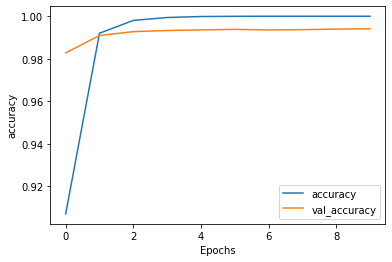

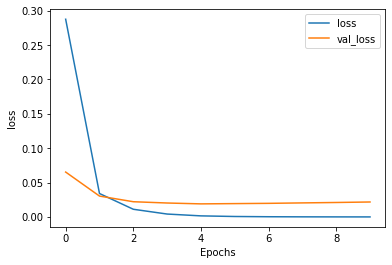

In [63]:
num_epochs = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)

dnn_history = dnn_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                        callbacks = [early_stopping_callback], verbose=1)

plot_graphs(dnn_history, "accuracy")
plot_graphs(dnn_history, "loss")

In [64]:
dnn_results = dnn_model.evaluate(test_padded, test_labels, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results[1]))

54/54 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9951
Regular dense network - test loss: 0.021720867604017258
Regular dense network - test accuracy: 0.9950710535049438


In [65]:
dnn_pred = (dnn_model.predict(test_padded) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: Regular dense neural network.")
print(classification_report(test_labels, dnn_pred))

A detailed report on the model performance:
Model type: Regular dense neural network.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3232
           1       1.00      0.99      1.00      3666

    accuracy                           1.00      6898
   macro avg       0.99      1.00      1.00      6898
weighted avg       1.00      1.00      1.00      6898



#### Recurrent neural network - LSTM.

In [66]:
# Recurrent LSTM network with word-embeddings dimension = 10

embedding_dim = 10

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(12),
    tf.keras.layers.Dense(12, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 145s 153ms/step - loss: 0.2427 - accuracy: 0.9060 - val_loss: 0.1114 - val_accuracy: 0.9755
Epoch 2/10
950/950 [==============================] - 158s 167ms/step - loss: 0.2055 - accuracy: 0.9282 - val_loss: 0.1587 - val_accuracy: 0.9518
Epoch 3/10
950/950 [==============================] - 157s 165ms/step - loss: 0.1433 - accuracy: 0.9564 - val_loss: 0.3521 - val_accuracy: 0.9072
Epoch 4/10
950/950 [==============================] - 155s 163ms/step - loss: 0.1103 - accuracy: 0.9661 - val_loss: 0.4503 - val_accuracy: 0.7583
Epoch 5/10
950/950 [==============================] - 156s 164ms/step - loss: 0.1131 - accuracy: 0.9629 - val_loss: 0.1117 - val_accuracy: 0.9707


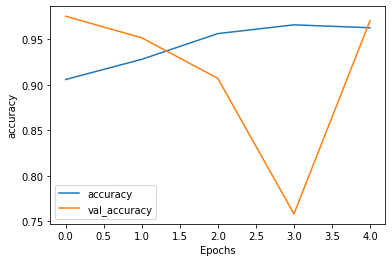

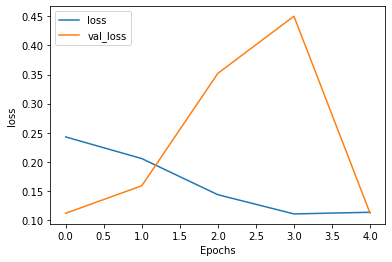

In [67]:
num_epochs = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)

lstm_history = lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback], verbose=1)

plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

As you can see in the above learning curve, the validation loss curve begins to increase as the training progresses which is a clear sign of overfitting. Thus, we introduce some regularization using a dropout layer with keep_prob = 0.75.

In [73]:
# Recurrent LSTM network with word-embeddings dimension = 10

embedding_dim = 10

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(12),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(12, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Epoch 1/10
950/950 [==============================] - 151s 159ms/step - loss: 0.2315 - accuracy: 0.9233 - val_loss: 0.1353 - val_accuracy: 0.9668
Epoch 2/10
950/950 [==============================] - 157s 165ms/step - loss: 0.1299 - accuracy: 0.9705 - val_loss: 0.1160 - val_accuracy: 0.9720
Epoch 3/10
950/950 [==============================] - 157s 166ms/step - loss: 0.1088 - accuracy: 0.9714 - val_loss: 0.0705 - val_accuracy: 0.9807
Epoch 4/10
950/950 [==============================] - 167s 176ms/step - loss: 0.0862 - accuracy: 0.9760 - val_loss: 0.0720 - val_accuracy: 0.9805


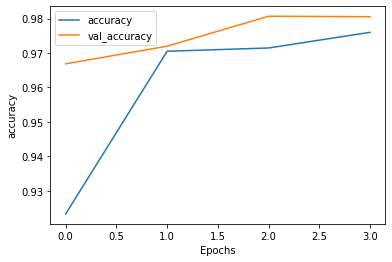

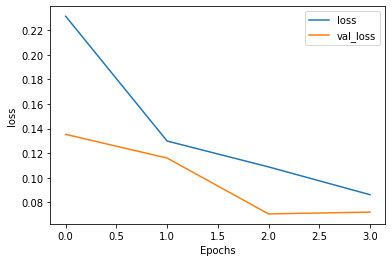

In [74]:
num_epochs = 10

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

In [78]:
lstm_results = lstm_model.evaluate(test_padded, test_labels, batch_size=128)

print('LSTM Model - test loss: {}'.format(lstm_results[0]))
print('LSTM Model - test accuracy: {}'.format(lstm_results[1]))

54/54 [==============================] - 0s 9ms/step - loss: 0.0699 - accuracy: 0.9826
LSTM Model - test loss: 0.0698920339345932
LSTM Model - test accuracy: 0.9826036691665649


In [79]:
lstm_pred = (lstm_model.predict(test_padded) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: LSTM recurrent network.")
print(classification_report(test_labels, lstm_pred))

A detailed report on the model performance:
Model type: LSTM recurrent network.
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3232
           1       0.98      0.99      0.98      3666

    accuracy                           0.98      6898
   macro avg       0.98      0.98      0.98      6898
weighted avg       0.98      0.98      0.98      6898



We notice that in the middle of the training process, the early stopping criteria has been met where the validation loss is increased than the validation loss from the previous epoch, which shows that the model is overshooting on the loss curve to some extent and diverging from the minimum instead of converging.

We have created a model predicting if a news is fake or not from its text content. Now let us train a deep neural network which will predict if a news is fake or not from its title. This is important because when we see the usecases of this model for a real world fake news classifier application, it is tedious to copy an entire 1000-2000 words length news article and easier to simply copy the title. Therefore we will experiment with a model on the same.

In [80]:
all_news_data_title = true_news_data.append(fake_news_data, ignore_index = True)

all_news_data_processed_title = all_news_data_title.copy()

all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_punctuations(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_nums(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_URL(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_html(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: remove_emoji(x))
all_news_data_processed_title["title"] = all_news_data_processed_title["title"].apply(lambda x: clean_stopwords(x))

all_news_data_processed_title['label'] = all_news_data_processed_title['label'].map( {'Fake':1, 'True':0} )

del all_news_data_processed_title["text"]
del all_news_data_processed_title["subject"]
del all_news_data_processed_title["date"]

all_news_data_processed_title = all_news_data_processed_title.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

all_news_data_processed_title.head(10)

,title,label
0,Jeb Bush Rally Becomes Counseling Session As S...,1
1,Michigan governor expects charges Flint crisis...,0
2,Syrian rebels army helicopter southwest Observ...,0
3,‘Christian’ ExMayor Raped YearOld Girl For Thr...,1
4,Grizzly MissSteppe How Washington Post Rewrote...,1
5,McCain RIPS GOP Brass Over Russian Hack Respon...,1
6,NANNY STATE GOVERNMENT S’MORES NO CHOCOLATE AN...,1
7,STUNNING PHOTOS EMERGE Of West Point Graduate ...,1
8,MEDIA IGNORES TRUMP’S FIRST RecordBreaking Chr...,1
9,Trumps Supreme Court nominee questions power a...,0


In [81]:
tf.random.set_seed(100)

temp = [x for x in all_news_data_processed_title["title"].tolist()]
train_sentences_title = temp[:training_size]
test_sentences_title = temp[training_size:]

temp2 = [x for x in all_news_data_processed_title["label"].tolist()]
train_labels_title = temp2[:training_size]
test_labels_title = temp2[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences_title = tokenizer.texts_to_sequences(train_sentences_title)
train_padded_title = pad_sequences(train_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences_title = tokenizer.texts_to_sequences(test_sentences_title)
test_padded_title = pad_sequences(test_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)


train_padded_title = np.array(train_padded_title)
train_labels_title = np.array(train_labels_title)

test_padded_title = np.array(test_padded_title)
test_labels_title = np.array(test_labels_title)

Epoch 1/10
950/950 [==============================] - 78s 82ms/step - loss: 0.4310 - accuracy: 0.8565 - val_loss: 0.1222 - val_accuracy: 0.9758
Epoch 2/10
950/950 [==============================] - 77s 81ms/step - loss: 0.0776 - accuracy: 0.9801 - val_loss: 0.0613 - val_accuracy: 0.9846
Epoch 3/10
950/950 [==============================] - 78s 82ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.0432 - val_accuracy: 0.9863
Epoch 4/10
950/950 [==============================] - 78s 83ms/step - loss: 0.0306 - accuracy: 0.9906 - val_loss: 0.0351 - val_accuracy: 0.9892
Epoch 5/10
950/950 [==============================] - 83s 87ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0316 - val_accuracy: 0.9901
Epoch 6/10
950/950 [==============================] - 79s 84ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0314 - val_accuracy: 0.9901
Epoch 7/10
950/950 [==============================] - 78s 82ms/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0301 - val_accuracy:

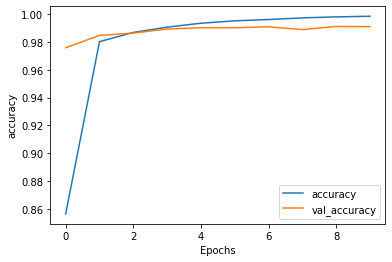

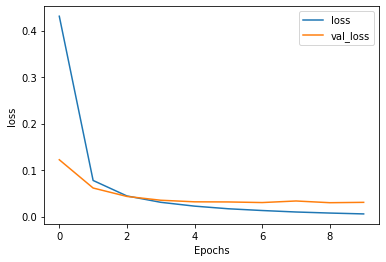

In [83]:
# Regular dense neural network with word-embeddings dimension = 5.

embedding_dim = 5

dnn_model_title = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model_title.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs_title = 10

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)

dnn_history_title = dnn_model_title.fit(train_padded_title, train_labels_title, epochs=num_epochs_title, validation_split=0.2,
                        callbacks = [early_stopping_callback], verbose=1)

plot_graphs(dnn_history_title, "accuracy")
plot_graphs(dnn_history_title, "loss")

In [85]:
dnn_results_title = dnn_model_title.evaluate(test_padded_title, test_labels_title, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results_title[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results_title[1]))

54/54 [==============================] - 0s 1ms/step - loss: 0.0301 - accuracy: 0.9903
Regular dense network - test loss: 0.03011171519756317
Regular dense network - test accuracy: 0.9902870655059814


In [86]:
dnn_pred_title = (dnn_model_title.predict(test_padded_title) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: Regular dense neural network.")
print(classification_report(test_labels_title, dnn_pred_title))

A detailed report on the model performance:
Model type: Regular dense neural network.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3303
           1       0.99      0.99      0.99      3595

    accuracy                           0.99      6898
   macro avg       0.99      0.99      0.99      6898
weighted avg       0.99      0.99      0.99      6898



In [88]:
dnn_model.save("saved_models//dnn-emb5-numep10")
lstm_model.save("saved_models//lstm-emb10-numep10")
dnn_model_title.save("saved_models//dnn_title-emb5-numep10")

INFO:tensorflow:Assets written to: saved_models//dnn-emb5-numep10\assets
INFO:tensorflow:Assets written to: saved_models//lstm-emb10-numep10\assets
INFO:tensorflow:Assets written to: saved_models//dnn_title-emb5-numep10\assets
